>>> 1. Fetching Data & Aligning Dates...
    Data Shape: (378, 5)
>>> 2. Running Expanding Window HMM (Stabilized)...


100%|██████████| 318/318 [01:27<00:00,  3.65it/s]


>>> 3. Visualizing Regimes...


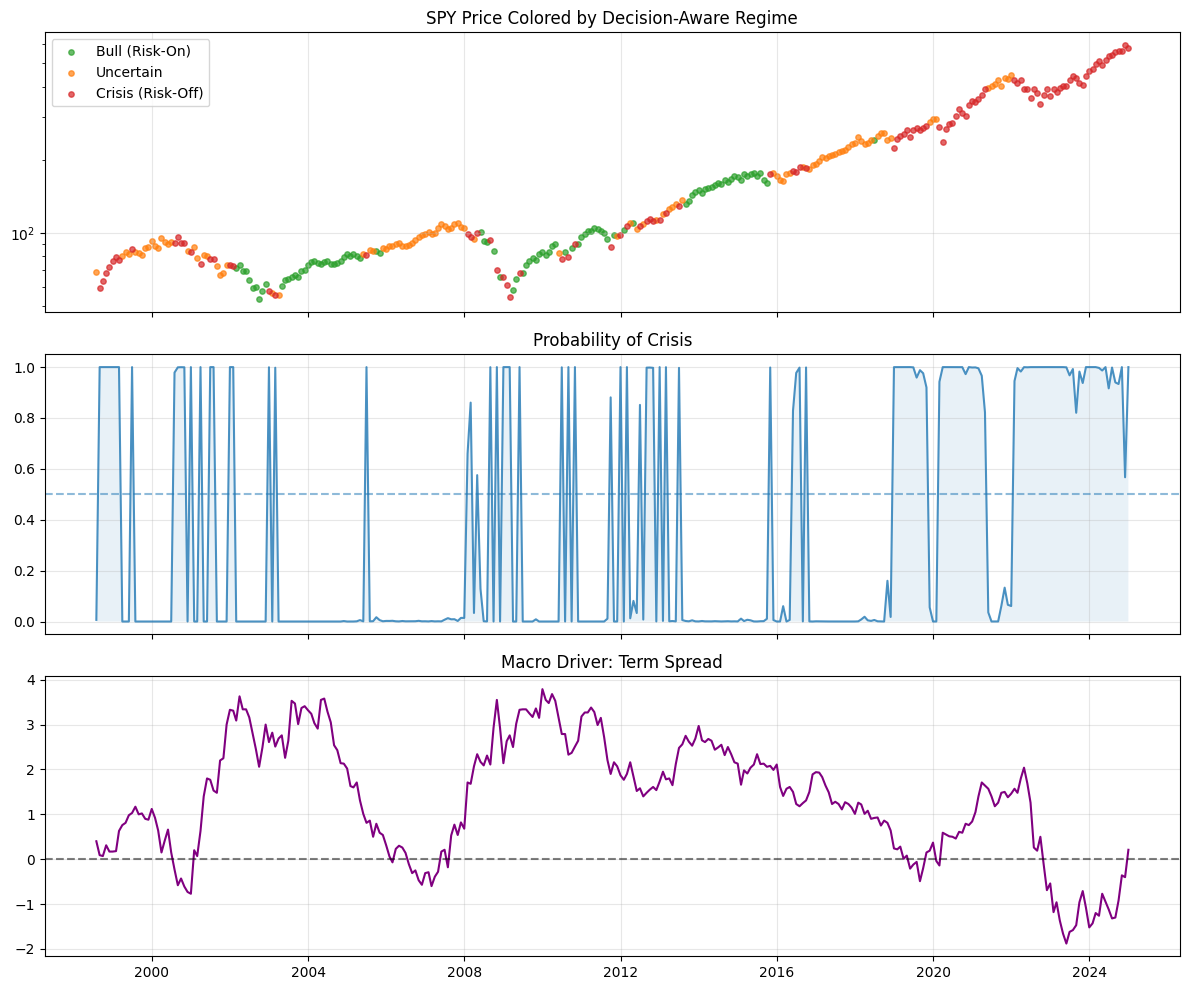


[Latest Regime Check]
                   SPY  Regime  Prob_Crisis
Date                                       
2024-08-31  553.570618     2.0     0.939815
2024-09-30  563.469849     2.0     0.933548
2024-10-31  560.154602     2.0     0.999998
2024-11-30  593.558533     2.0     0.566926
2024-12-31  577.334290     2.0     0.999931


In [67]:
# 1. HMM 3분할 수정버전 (Term Spread)
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

class RobustRegimeClassifier:
    def __init__(self, start_date='1990-01-01', end_date='2024-12-31', min_window=60):
        self.start_date = start_date
        self.end_date = end_date
        self.min_window = min_window  # 초기 학습 데이터 길이 (개월)
        self.n_states = 3             # 0:Bull, 1:Uncertain, 2:Crisis

    def fetch_data(self):
        print(">>> 1. Fetching Data & Aligning Dates...")

        # A. Market Data (SPY)
        spy = yf.download(
            'SPY',
            start=self.start_date,
            end=self.end_date,
            interval='1mo',
            progress=False,
            auto_adjust=True
        )['Close']

        if isinstance(spy, pd.DataFrame):
            spy = spy.iloc[:, 0]

        spy.index = spy.index.to_period('M').to_timestamp('M')

        # Feature Engineering
        returns = np.log(spy / spy.shift(1))
        volatility = returns.rolling(window=6).std()

        # B. Macro Data (FRED)
        fred_tickers = ['T10Y3M', 'NFCI']
        macro = web.DataReader(
            fred_tickers,
            'fred',
            self.start_date,
            self.end_date
        ).resample('M').last()

        macro.index = macro.index.to_period('M').to_timestamp('M')

        # Merge
        df1 = pd.DataFrame({
            'SPY': spy,
            'Returns': returns,
            'Vol': volatility
        })

        df1 = df1.join(macro).ffill().dropna()

        print(f"    Data Shape: {df1.shape}")
        return df1

    def run_expanding_window_hmm(self, df1):
        print(">>> 2. Running Expanding Window HMM (Stabilized)...")

        regime_preds = []
        prob_preds = []

        feature_cols = ['Returns', 'Vol', 'T10Y3M']

        for t in tqdm(range(self.min_window, len(df1))):

            train_data = df1.iloc[:t + 1]
            X_train = train_data[feature_cols].values

            # Standardization
            means = X_train.mean(axis=0)
            stds = X_train.std(axis=0) + 1e-6
            X_scaled = (X_train - means) / stds

            best_score = -np.inf
            best_model = None

            for _ in range(5):
                try:
                    model = GaussianHMM(
                        n_components=self.n_states,
                        covariance_type="diag",
                        n_iter=1000,
                        tol=1e-4,
                        min_covar=1e-3,
                        random_state=None
                    )
                    model.fit(X_scaled)

                    score = model.score(X_scaled)
                    if score > best_score:
                        best_score = score
                        best_model = model
                except:
                    continue

            if best_model is None:
                best_model = model

            hidden_states = best_model.predict(X_scaled)
            current_state = hidden_states[-1]
            current_probs = best_model.predict_proba(X_scaled)[-1]

            # --- Dynamic State Re-ordering (Economic Score) ---
            state_scores = []

            alpha = 0.7   # Cycle
            beta  = 0.3   # Stress
            gamma = 0.2   # Return

            for i in range(self.n_states):
                m = best_model.means_[i]

                cycle  = -m[2]   # Term Spread
                stress =  m[1]   # Volatility
                ret    =  m[0]   # Returns

                score = alpha * cycle + beta * stress - gamma * ret
                state_scores.append((i, score))

            sorted_states = sorted(state_scores, key=lambda x: x[1])
            mapping = {old: new for new, (old, _) in enumerate(sorted_states)}

            final_regime = mapping[current_state]
            sorted_indices = [old for old, _ in sorted_states]
            final_probs = current_probs[sorted_indices]

            regime_preds.append(final_regime)
            prob_preds.append(final_probs)

        result_index = df1.index[self.min_window:]
        res_df = pd.DataFrame(index=result_index)
        res_df['Regime'] = regime_preds
        res_df[['Prob_Bull', 'Prob_Uncertain', 'Prob_Crisis']] = prob_preds

        return df1.join(res_df).dropna()

    def visualize(self, df1):
        print(">>> 3. Visualizing Regimes...")

        fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

        colors = ['#2ca02c', '#ff7f0e', '#d62728']
        labels = ['Bull (Risk-On)', 'Uncertain', 'Crisis (Risk-Off)']

        for i in range(3):
            mask = df1['Regime'] == i
            ax[0].scatter(
                df1.index[mask],
                df1['SPY'][mask],
                s=15,
                c=colors[i],
                label=labels[i],
                alpha=0.7
            )

        ax[0].set_title('SPY Price Colored by Decision-Aware Regime')
        ax[0].set_yscale('log')
        ax[0].legend(loc='upper left')
        ax[0].grid(True, alpha=0.3)

        ax[1].plot(df1.index, df1['Prob_Crisis'], alpha=0.8)
        ax[1].fill_between(df1.index, 0, df1['Prob_Crisis'], alpha=0.1)
        ax[1].axhline(0.5, linestyle='--', alpha=0.5)
        ax[1].set_title('Probability of Crisis')
        ax[1].grid(True, alpha=0.3)

        ax[2].plot(df1.index, df1['T10Y3M'], color='purple', label='Term Spread (T10Y3M)')
        ax[2].axhline(0, color='black', linestyle='--', alpha=0.5)
        ax[2].set_title('Macro Driver: Term Spread')
        ax[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    classifier = RobustRegimeClassifier()

    df1 = classifier.fetch_data()
    labeled_df1 = classifier.run_expanding_window_hmm(df1)
    classifier.visualize(labeled_df1)

    print("\n[Latest Regime Check]")
    print(labeled_df1[['SPY', 'Regime', 'Prob_Crisis']].tail())


>>> 1. Fetching Data & Aligning Dates...
    Data Shape: (378, 6)
>>> 2. Running Expanding Window HMM (Stabilized)...


100%|██████████| 318/318 [01:34<00:00,  3.38it/s]


>>> 3. Visualizing Regimes...


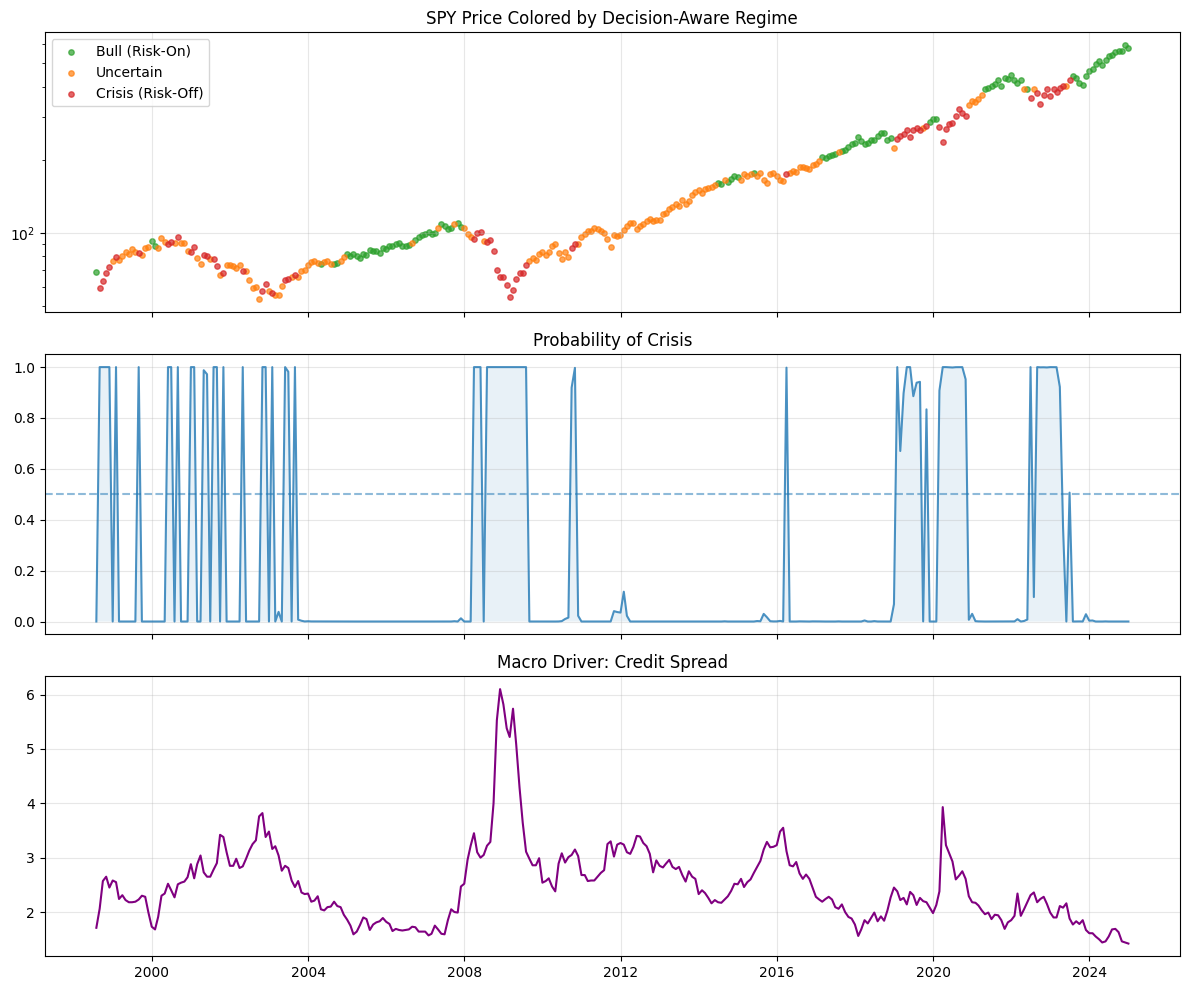


[Latest Regime Check]
                   SPY  Regime   Prob_Crisis
Date                                        
2024-08-31  553.570618     0.0  1.393886e-10
2024-09-30  563.469849     0.0  1.116841e-10
2024-10-31  560.154602     0.0  3.477684e-13
2024-11-30  593.558533     0.0  1.263283e-06
2024-12-31  577.334290     0.0  2.431827e-05


In [68]:
# 2. HMM 3분할 수정전버전 (Credit Spread 사용)

import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

class RobustRegimeClassifier:
    def __init__(self, start_date='1990-01-01', end_date='2024-12-31', min_window=60):
        self.start_date = start_date
        self.end_date = end_date
        self.min_window = min_window
        self.n_states = 3   # 0:Bull, 1:Uncertain, 2:Crisis

    def fetch_data(self):
        print(">>> 1. Fetching Data & Aligning Dates...")

        # A. Market Data (SPY)
        spy = yf.download(
            'SPY',
            start=self.start_date,
            end=self.end_date,
            interval='1mo',
            progress=False,
            auto_adjust=True
        )['Close']

        if isinstance(spy, pd.DataFrame):
            spy = spy.iloc[:, 0]

        spy.index = spy.index.to_period('M').to_timestamp('M')

        # Feature Engineering
        returns = np.log(spy / spy.shift(1))
        volatility = returns.rolling(window=6).std()

        # B. Macro Data (FRED)
        fred_tickers = ['BAA10Y', 'T10Y3M', 'NFCI']
        macro = web.DataReader(
            fred_tickers,
            'fred',
            self.start_date,
            self.end_date
        ).resample('M').last()

        macro.index = macro.index.to_period('M').to_timestamp('M')

        # Merge
        df2 = pd.DataFrame({
            'SPY': spy,
            'Returns': returns,
            'Vol': volatility
        })

        df2 = df2.join(macro).ffill().dropna()

        print(f"    Data Shape: {df2.shape}")
        return df2

    def run_expanding_window_hmm(self, df2):
        print(">>> 2. Running Expanding Window HMM (Stabilized)...")

        regime_preds = []
        prob_preds = []

        feature_cols = ['Returns', 'Vol', 'BAA10Y']

        for t in tqdm(range(self.min_window, len(df2))):

            train_data = df2.iloc[:t + 1].copy()
            X_train = train_data[feature_cols].values

            # Standardization
            means = X_train.mean(axis=0)
            stds = X_train.std(axis=0) + 1e-6
            X_scaled = (X_train - means) / stds

            best_score = -np.inf
            best_model = None

            for _ in range(5):
                try:
                    model = GaussianHMM(
                        n_components=self.n_states,
                        covariance_type="diag",
                        n_iter=1000,
                        tol=1e-4,
                        min_covar=1e-3,
                        random_state=None
                    )
                    model.fit(X_scaled)

                    score = model.score(X_scaled)
                    if score > best_score:
                        best_score = score
                        best_model = model
                except:
                    continue

            if best_model is None:
                best_model = model

            hidden_states = best_model.predict(X_scaled)
            current_state = hidden_states[-1]
            current_probs = best_model.predict_proba(X_scaled)[-1]

            # --- Dynamic State Re-ordering (Credit-Centric Logic) ---
            state_scores = []

            weight_spread = 0.5
            weight_vol = 0.3
            weight_ret = 0.2

            for i in range(self.n_states):
                m = best_model.means_[i]

                score = (
                    weight_spread * m[2] +
                    weight_vol    * m[1] -
                    weight_ret    * m[0]
                )
                state_scores.append((i, score))

            sorted_states = sorted(state_scores, key=lambda x: x[1])
            mapping = {old: new for new, (old, _) in enumerate(sorted_states)}

            final_regime = mapping[current_state]
            sorted_indices = [old for old, _ in sorted_states]
            final_probs = current_probs[sorted_indices]

            regime_preds.append(final_regime)
            prob_preds.append(final_probs)

        result_index = df2.index[self.min_window:]
        res_df = pd.DataFrame(index=result_index)
        res_df['Regime'] = regime_preds
        res_df[['Prob_Bull', 'Prob_Uncertain', 'Prob_Crisis']] = prob_preds

        return df2.join(res_df).dropna()

    def visualize(self, df2):
        print(">>> 3. Visualizing Regimes...")

        fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

        colors = ['#2ca02c', '#ff7f0e', '#d62728']
        labels = ['Bull (Risk-On)', 'Uncertain', 'Crisis (Risk-Off)']

        for i in range(3):
            mask = df2['Regime'] == i
            ax[0].scatter(
                df2.index[mask],
                df2['SPY'][mask],
                s=15,
                c=colors[i],
                label=labels[i],
                alpha=0.7
            )

        ax[0].set_title('SPY Price Colored by Decision-Aware Regime')
        ax[0].set_yscale('log')
        ax[0].legend(loc='upper left')
        ax[0].grid(True, alpha=0.3)

        ax[1].plot(df2.index, df2['Prob_Crisis'], alpha=0.8)
        ax[1].fill_between(df2.index, 0, df2['Prob_Crisis'], alpha=0.1)
        ax[1].axhline(0.5, linestyle='--', alpha=0.5)
        ax[1].set_title('Probability of Crisis')
        ax[1].grid(True, alpha=0.3)

        ax[2].plot(df2.index, df2['BAA10Y'], color='purple', label='Credit Spread (BAA10Y)')
        ax[2].set_title('Macro Driver: Credit Spread')
        ax[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    classifier = RobustRegimeClassifier()

    df2 = classifier.fetch_data()
    labeled_df2 = classifier.run_expanding_window_hmm(df2)
    classifier.visualize(labeled_df2)

    print("\n[Latest Regime Check]")
    print(labeled_df2[['SPY', 'Regime', 'Prob_Crisis']].tail())

>>> 1. Fetching Data & Aligning Dates...
    Data Shape: (378, 4)
>>> 2. Running Expanding Window HMM (Binary Classification)...


100%|██████████| 318/318 [00:37<00:00,  8.46it/s]


>>> 3. Visualizing Binary Regimes (Separated Plots)...


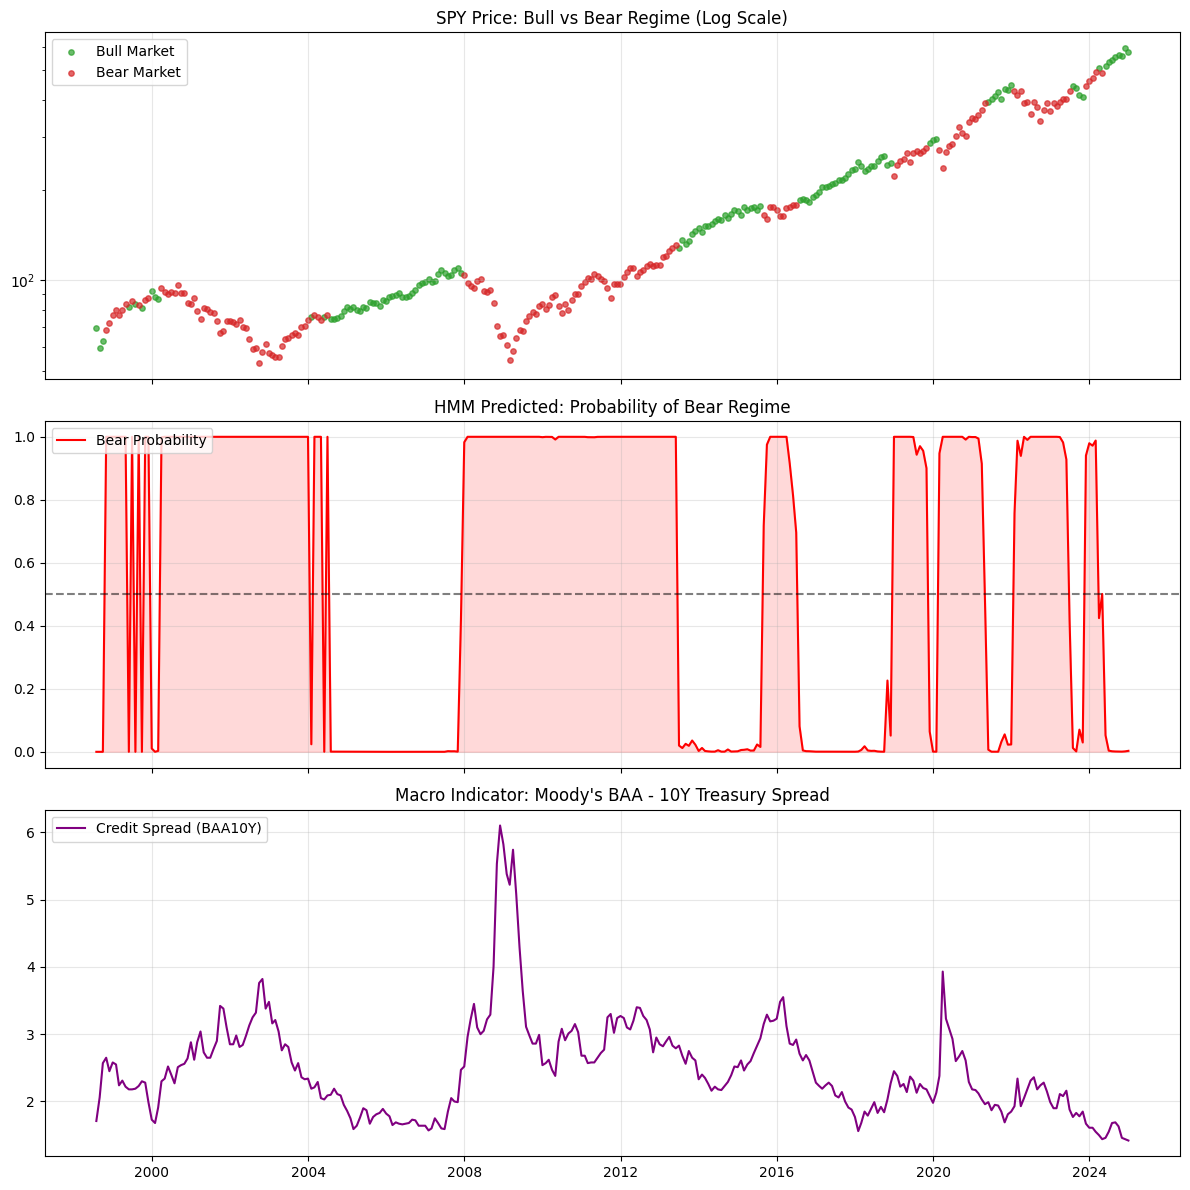


[Latest Regime Check]
                   SPY  Regime  Prob_Bear  BAA10Y
Date                                             
2024-08-31  553.570618     0.0   0.001068    1.69
2024-09-30  563.469849     0.0   0.000983    1.63
2024-10-31  560.154602     0.0   0.000604    1.46
2024-11-30  593.558533     0.0   0.001377    1.44
2024-12-31  577.334290     0.0   0.003099    1.42


In [69]:
# 3. HMM 2분할 모델 (변수명 df3로 수정됨)

import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

class RobustRegimeClassifier:
    def __init__(self, start_date='1990-01-01', end_date='2024-12-31', min_window=60):
        self.start_date = start_date
        self.end_date = end_date
        self.min_window = min_window
        # 3분할에서 2분할로 변경 (0: Bull, 1: Bear)
        self.n_states = 2

    def fetch_data(self):
        print(">>> 1. Fetching Data & Aligning Dates...")

        # A. Market Data (SPY)
        spy = yf.download(
            'SPY',
            start=self.start_date,
            end=self.end_date,
            interval='1mo',
            progress=False,
            auto_adjust=True
        )['Close']

        if isinstance(spy, pd.DataFrame):
            spy = spy.iloc[:, 0]

        spy.index = spy.index.to_period('M').to_timestamp('M')

        # Feature Engineering
        returns = np.log(spy / spy.shift(1))
        volatility = returns.rolling(window=6).std()

        # B. Macro Data (FRED) - Credit Spread 위주
        fred_tickers = ['BAA10Y']
        macro = web.DataReader(
            fred_tickers,
            'fred',
            self.start_date,
            self.end_date
        ).resample('M').last()

        macro.index = macro.index.to_period('M').to_timestamp('M')

        # Merge
        df3 = pd.DataFrame({
            'SPY': spy,
            'Returns': returns,
            'Vol': volatility
        })

        df3 = df3.join(macro).ffill().dropna()

        print(f"    Data Shape: {df3.shape}")
        return df3

    def run_expanding_window_hmm(self, df3):
        print(">>> 2. Running Expanding Window HMM (Binary Classification)...")

        regime_preds = []
        prob_preds = []

        feature_cols = ['Returns', 'Vol', 'BAA10Y']

        for t in tqdm(range(self.min_window, len(df3))):
            train_data = df3.iloc[:t + 1].copy()
            X_train = train_data[feature_cols].values

            # Standardization
            means = X_train.mean(axis=0)
            stds = X_train.std(axis=0) + 1e-6
            X_scaled = (X_train - means) / stds

            best_score = -np.inf
            best_model = None

            # 모델 안정성을 위해 여러 번 시도
            for _ in range(5):
                try:
                    model = GaussianHMM(
                        n_components=self.n_states,
                        covariance_type="diag",
                        n_iter=1000,
                        tol=1e-4,
                        min_covar=1e-3,
                        random_state=None
                    )
                    model.fit(X_scaled)
                    score = model.score(X_scaled)
                    if score > best_score:
                        best_score = score
                        best_model = model
                except:
                    continue

            if best_model is None:
                best_model = model

            current_state = best_model.predict(X_scaled)[-1]
            current_probs = best_model.predict_proba(X_scaled)[-1]

            # --- Dynamic State Re-ordering (Bull/Bear Logic) ---
            # 점수가 높을수록 'Bear'에 가깝도록 설정
            # 높은 스프레드(+), 높은 변동성(+), 낮은 수익률(-)
            state_scores = []
            for i in range(self.n_states):
                m = best_model.means_[i]
                score = (0.5 * m[2]) + (0.3 * m[1]) - (0.2 * m[0])
                state_scores.append((i, score))

            # 점수가 낮은 순서대로 정렬: 0번이 Bull(호재), 1번이 Bear(악재)
            sorted_states = sorted(state_scores, key=lambda x: x[1])
            mapping = {old: new for new, (old, _) in enumerate(sorted_states)}

            final_regime = mapping[current_state]
            sorted_indices = [old for old, _ in sorted_states]
            final_probs = current_probs[sorted_indices]

            regime_preds.append(final_regime)
            prob_preds.append(final_probs)

        result_index = df3.index[self.min_window:]
        res_df = pd.DataFrame(index=result_index)
        res_df['Regime'] = regime_preds
        res_df[['Prob_Bull', 'Prob_Bear']] = prob_preds

        return df3.join(res_df).dropna()

    def visualize(self, df3):
        print(">>> 3. Visualizing Binary Regimes (Separated Plots)...")

        # Plot 개수를 3개로 늘림 (Price / Bear Prob / Credit Spread)
        fig, ax = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

        colors = ['#2ca02c', '#d62728'] # Green: Bull, Red: Bear
        labels = ['Bull Market', 'Bear Market']

        # 1. 상단: SPY 가격 및 Regime 표시
        for i in range(2):
            mask = df3['Regime'] == i
            ax[0].scatter(
                df3.index[mask],
                df3['SPY'][mask],
                s=15,
                c=colors[i],
                label=labels[i],
                alpha=0.7
            )

        ax[0].set_title('SPY Price: Bull vs Bear Regime (Log Scale)')
        ax[0].set_yscale('log')
        ax[0].legend(loc='upper left')
        ax[0].grid(True, alpha=0.3)

        # 2. 중단: Bear 확률 (HMM Output)
        ax[1].plot(df3.index, df3['Prob_Bear'], color='red', lw=1.5, label='Bear Probability')
        ax[1].fill_between(df3.index, 0, df3['Prob_Bear'], color='red', alpha=0.15)
        ax[1].axhline(0.5, linestyle='--', color='black', alpha=0.5)
        ax[1].set_title('HMM Predicted: Probability of Bear Regime')
        ax[1].set_ylim(-0.05, 1.05)
        ax[1].legend(loc='upper left')
        ax[1].grid(True, alpha=0.3)

        # 3. 하단: Credit Spread (Macro Driver)
        ax[2].plot(df3.index, df3['BAA10Y'], color='purple', lw=1.5, label='Credit Spread (BAA10Y)')
        ax[2].set_title('Macro Indicator: Moody\'s BAA - 10Y Treasury Spread')
        ax[2].legend(loc='upper left')
        ax[2].grid(True, alpha=0.3)

        # X축 날짜 포맷 정리 및 레이아웃 최적화
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    classifier = RobustRegimeClassifier()

    # 변수명을 df3로 모두 변경하였습니다.
    df3 = classifier.fetch_data()
    labeled_df3 = classifier.run_expanding_window_hmm(df3)
    classifier.visualize(labeled_df3)

    print("\n[Latest Regime Check]")
    print(labeled_df3[['SPY', 'Regime', 'Prob_Bear', 'BAA10Y']].tail())

>>> [Model 4] 실행 및 데이터 갱신 중...
--- [Binary Model] 데이터 수집 (1990-01-01 ~ 2024-12-31) ---
 -> 데이터 확보 완료: 384개월

--- [Performance Check: 2-State Model] ---
               count  Ann_Return  Sharpe
Regime                                  
Bear (Cash)       65        1.75    0.08
Bull (Equity)    283       12.84    1.00


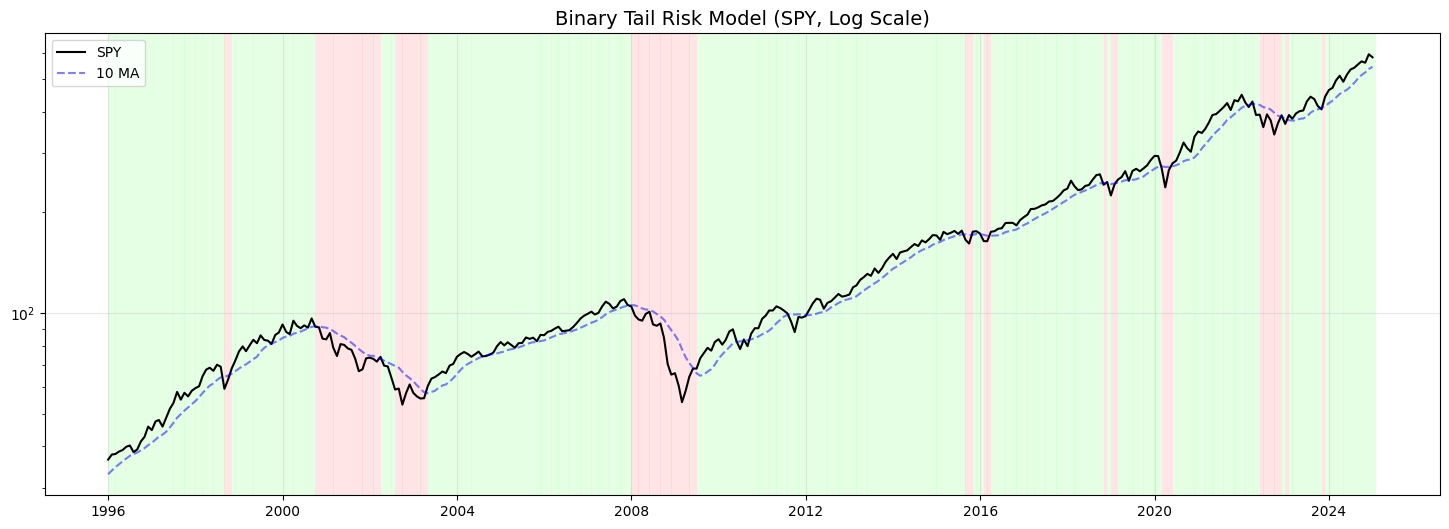

In [93]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from datetime import datetime


class BinaryRegimePipe:
    """
    [Binary Version]
    - Data: yfinance (Price) + FRED (Macro)
    - Logic: 2-State (Risk-On vs Risk-Off)
    - Philosophy: Remove 'Sideways'. Treat minor dips as noise (Stay Bull).
                  Only switch to Bear on 'Confirmed' signals.
    """
    def __init__(self, start_date='1990-01-01'):
        self.start = start_date
        self.end = '2024-12-31'
        self.df4 = pd.DataFrame()

    def fetch_data(self):
        print(f"--- [Binary Model] 데이터 수집 ({self.start} ~ {self.end}) ---")
        try:
            # 1. Price (yfinance)
            df_stock = yf.download(
                'SPY',
                start=self.start,
                end=self.end,
                progress=False
            )

            # 🔧 MultiIndex 컬럼 평탄화 (핵심)
            if isinstance(df_stock.columns, pd.MultiIndex):
                df_stock.columns = df_stock.columns.get_level_values(0)

            # Adj Close 우선, 없으면 Close
            if 'Adj Close' in df_stock.columns:
                df_stock = df_stock[['Adj Close']].rename(columns={'Adj Close': 'Close'})
            elif 'Close' in df_stock.columns:
                df_stock = df_stock[['Close']]
            else:
                raise ValueError("No Close or Adj Close column in yfinance data")

            # 2. Macro (FRED)
            df_macro = web.DataReader(
                ['VIXCLS', 'T10Y2Y'],
                'fred',
                self.start,
                self.end
            )

            # Index 정리
            df_stock.index = pd.to_datetime(df_stock.index)
            df_macro.index = pd.to_datetime(df_macro.index)

            # Daily Merge -> Monthly Resample
            df_daily = pd.concat([df_stock['Close'], df_macro], axis=1).ffill()

            df_monthly = pd.DataFrame()
            df_monthly['SP500'] = df_daily['Close'].resample('M').last()
            df_monthly['VIX'] = df_daily['VIXCLS'].resample('M').mean()
            df_monthly['Yield_Spread'] = df_daily['T10Y2Y'].resample('M').mean()

            self.df4 = df_monthly.dropna()
            print(f" -> 데이터 확보 완료: {len(self.df4)}개월")
            return self.df4

        except Exception as e:
            print(f"Error: {e}")
            return pd.DataFrame()

    def apply_binary_logic(self):
        if self.df4.empty:
            return

        self.df4['MA_10'] = self.df4['SP500'].rolling(window=10).mean()
        self.df4['VIX_Threshold'] = self.df4['VIX'].rolling(window=36).quantile(0.80)

        data = self.df4.dropna().copy()
        regimes = []
        current_state = 1

        for i in range(len(data)):
            row = data.iloc[i]

            is_uptrend = row['SP500'] > row['MA_10']
            is_fear = row['VIX'] > row['VIX_Threshold']
            is_inverted = row['Yield_Spread'] < 0.0

            next_state = current_state

            if current_state == 1:
                if not is_uptrend and (is_fear or is_inverted):
                    next_state = 0
            else:
                if is_uptrend:
                    next_state = 1

            regimes.append(next_state)
            current_state = next_state

        data['Regime'] = regimes
        self.df4 = data
        return self.df4

    def validate_performance(self):
        if 'Regime' not in self.df4.columns:
            return

        self.df4['Next_Ret'] = self.df4['SP500'].pct_change().shift(-1)

        print("\n--- [Performance Check: 2-State Model] ---")
        stats = self.df4.groupby('Regime')['Next_Ret'].agg(['count', 'mean', 'std'])

        stats['Ann_Return'] = stats['mean'] * 12 * 100
        stats['Ann_Vol'] = stats['std'] * (12 ** 0.5) * 100
        stats['Sharpe'] = stats['Ann_Return'] / stats['Ann_Vol']

        label_map = {0: 'Bear (Cash)', 1: 'Bull (Equity)'}
        stats.index = stats.index.map(label_map)

        print(stats[['count', 'Ann_Return', 'Sharpe']].round(2))
        return stats

    def visualize(self):
        if self.df4.empty:
            return

        df4 = self.df4
        plt.figure(figsize=(18, 6))

        plt.plot(df4.index, df4['SP500'],
                 color='black', linewidth=1.5, label='SPY')

        plt.plot(df4.index, df4['MA_10'],
                 color='blue', linestyle='--', alpha=0.5, label='10 MA')

        colors = {0: '#ffcccc', 1: '#ccffcc'}

        for i in range(len(df4)):
            date = df4.index[i]
            state = df4['Regime'].iloc[i]
            plt.axvspan(
                date,
                date + pd.Timedelta(days=32),
                facecolor=colors[state],
                edgecolor='none',
                alpha=0.5
            )

        plt.title('Binary Tail Risk Model (SPY, Log Scale)', fontsize=14)
        plt.yscale('log')
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.show()


if __name__ == "__main__":
    print(">>> [Model 4] 실행 및 데이터 갱신 중...")

    pipe = BinaryRegimePipe()
    raw_data = pipe.fetch_data()
    df4 = pipe.apply_binary_logic()
    pipe.validate_performance()
    pipe.visualize()


>>> [Regime Comparison] Aligning data and calculating mismatches...

[Mismatch Ratios vs Model 4 (Rule-Based)]
1. HMM (Term Spread, 3-Split) Mismatch: 33.65%
2. HMM (Credit Spread, 3-Split) Mismatch: 20.75%
3. HMM (Credit Spread, 2-Split) Mismatch: 40.88%


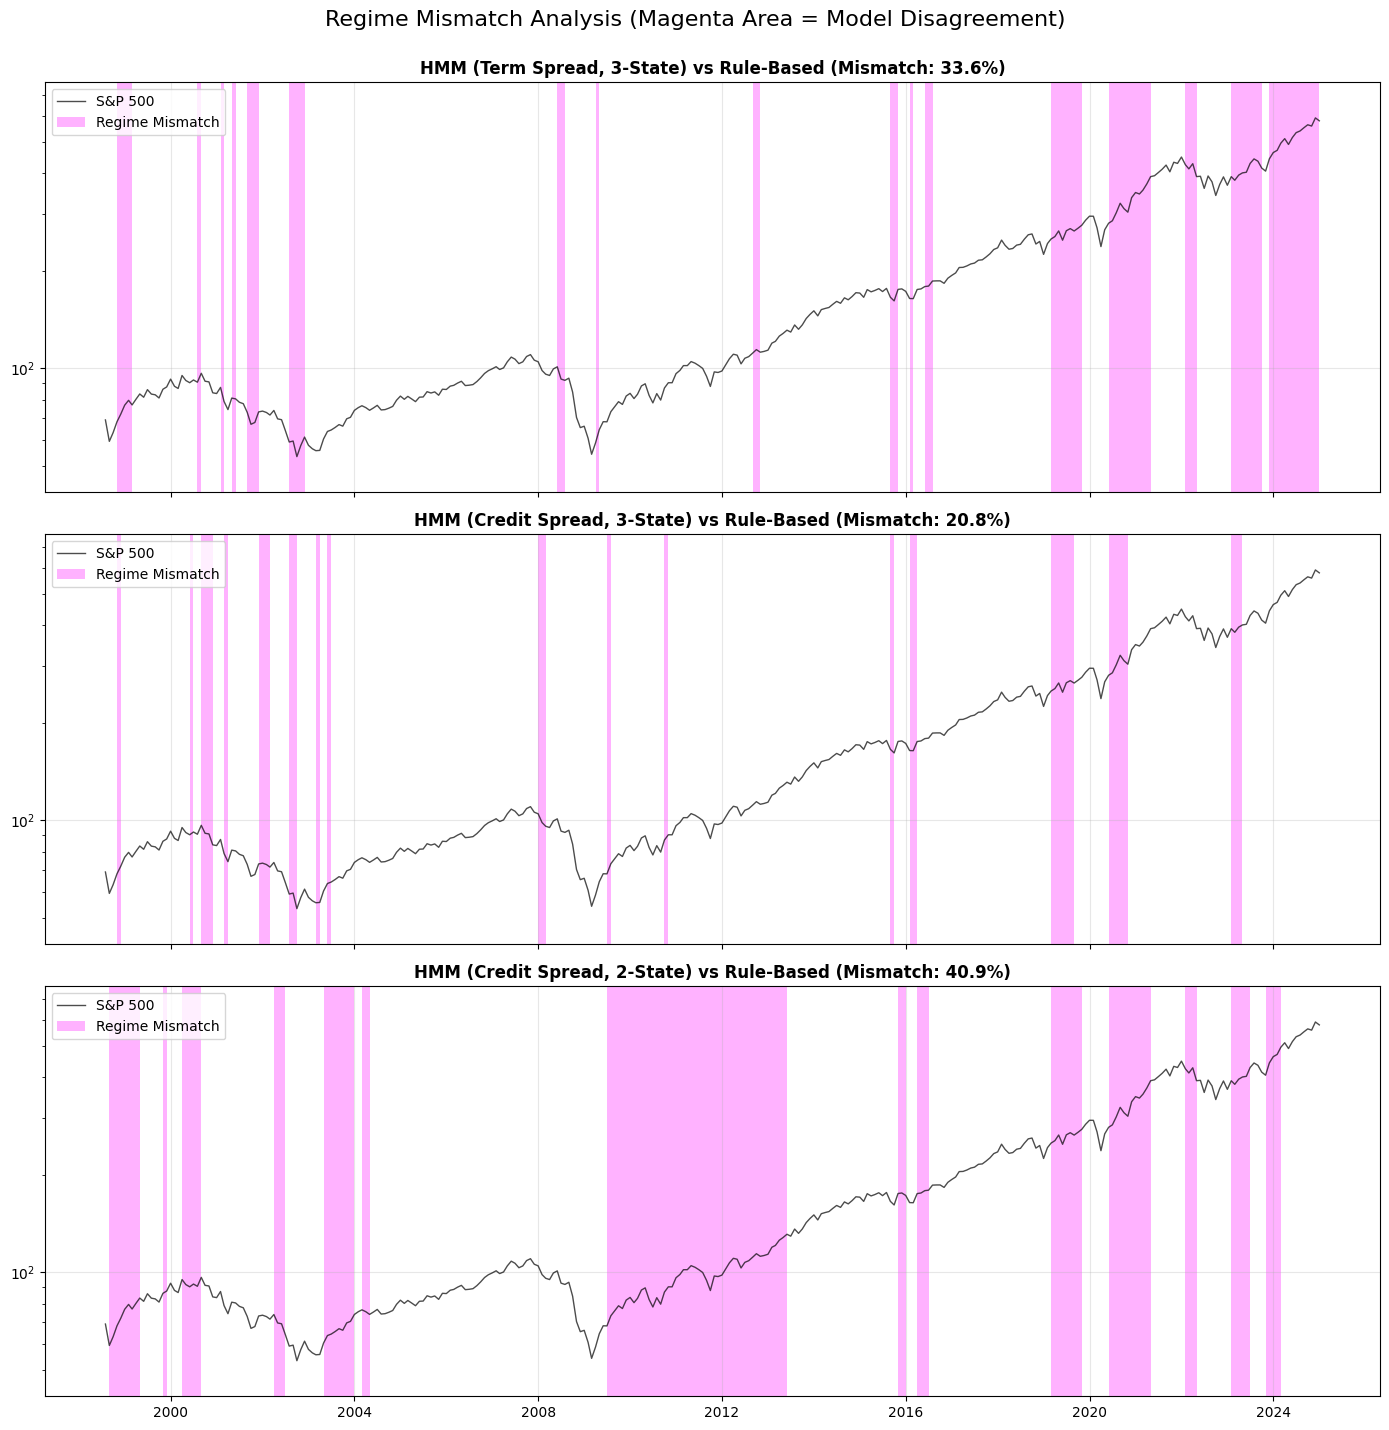

In [94]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def run_comparison_analysis(df1, df2, df3, df4):
    print(">>> [Regime Comparison] Aligning data and calculating mismatches...")

    # --- 1. 데이터 인덱스 통일 (월초 기준) ---
    # 각 데이터프레임의 복사본 생성하여 원본 보존
    d1, d2, d3, d4 = df1.copy(), df2.copy(), df3.copy(), df4.copy()

    # 인덱스를 모두 'YYYY-MM-01' 형태로 통일
    for df in [d1, d2, d3, d4]:
        df.index = df.index.to_period('M').to_timestamp('M')

    # 공통 기간 추출 (Inner Join)
    common_idx = d1.index.intersection(d2.index).intersection(d3.index).intersection(d4.index)
    d1, d2, d3, d4 = d1.loc[common_idx], d2.loc[common_idx], d3.loc[common_idx], d4.loc[common_idx]

    # --- 2. Regime Binary 변환 (Model 4: 1=Bull, 0=Bear 기준) ---

    # Model 1 (3-State): 0(Bull), 1(Uncertain) -> 1(Bull) / 2(Crisis) -> 0(Bear)
    s1 = d1['Regime'].apply(lambda x: 0 if x == 2 else 1)

    # Model 2 (3-State): 0(Bull), 1(Uncertain) -> 1(Bull) / 2(Crisis) -> 0(Bear)
    s2 = d2['Regime'].apply(lambda x: 0 if x == 2 else 1)

    # Model 3 (2-State): 0(Bull) -> 1(Bull) / 1(Bear) -> 0(Bear)
    s3 = d3['Regime'].apply(lambda x: 0 if x == 1 else 1)

    # Model 4 (Rule-Based): 이미 1(Bull), 0(Bear)
    s4 = d4['Regime']

    # 통합 DataFrame 생성
    comp_df = pd.DataFrame({
        'Price': d4['SP500'], # 가격은 Model 4의 SP500 사용
        'M1': s1,
        'M2': s2,
        'M3': s3,
        'M4': s4
    })

    # --- 3. 불일치 비율 계산 ---
    mismatch_1_4 = (comp_df['M1'] != comp_df['M4']).mean() * 100
    mismatch_2_4 = (comp_df['M2'] != comp_df['M4']).mean() * 100
    mismatch_3_4 = (comp_df['M3'] != comp_df['M4']).mean() * 100

    print(f"\n[Mismatch Ratios vs Model 4 (Rule-Based)]")
    print(f"1. HMM (Term Spread, 3-Split) Mismatch: {mismatch_1_4:.2f}%")
    print(f"2. HMM (Credit Spread, 3-Split) Mismatch: {mismatch_2_4:.2f}%")
    print(f"3. HMM (Credit Spread, 2-Split) Mismatch: {mismatch_3_4:.2f}%")

    # --- 4. 시각화 (3개 subplot) ---
    fig, axes = plt.subplots(3, 1, figsize=(14, 15), sharex=True)

    comparisons = [
        ('M1', 'HMM (Term Spread, 3-State)', mismatch_1_4),
        ('M2', 'HMM (Credit Spread, 3-State)', mismatch_2_4),
        ('M3', 'HMM (Credit Spread, 2-State)', mismatch_3_4)
    ]

    for ax, (col, name, ratio) in zip(axes, comparisons):
        # 1) 주가 차트 (Log Scale)
        ax.plot(comp_df.index, comp_df['Price'], color='black', lw=1, alpha=0.7, label='S&P 500')
        ax.set_yscale('log')

        # 2) 불일치 구간 색칠 (Mismatch Highlighting)
        # 두 모델의 값이 다른 경우 True인 마스크 생성
        mismatch_mask = comp_df[col] != comp_df['M4']

        # 불일치 구간 칠하기
        # fill_between을 사용하여 불일치하는 날짜 구간을 칠함
        # y축 전체를 칠하기 위해 transform 사용
        import matplotlib.transforms as mtransforms
        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

        ax.fill_between(comp_df.index, 0, 1, where=mismatch_mask,
                        facecolor='magenta', alpha=0.3, transform=trans, label='Regime Mismatch')

        # 3) 타이틀 및 스타일
        ax.set_title(f"{name} vs Rule-Based (Mismatch: {ratio:.1f}%)", fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left')

    plt.suptitle('Regime Mismatch Analysis (Magenta Area = Model Disagreement)', fontsize=16, y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- 실행 블록 ---
if __name__ == "__main__":
    # 전제: 앞선 코드 셀들이 실행되어 labeled_df1, labeled_df2, labeled_df3, df4가 존재해야 함
    try:
        run_comparison_analysis(labeled_df1, labeled_df2, labeled_df3, df4)
    except NameError:
        print("Error: 데이터프레임이 정의되지 않았습니다. 앞선 모델 코드들을 먼저 실행해주세요.")